In [10]:
from Regression import Regression
from Franke import FrankeCentered, FrankeCenteredNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
from sklearn.utils import resample
import skimage.measure
import scipy.stats
import time
from imageio import imread
from tqdm import tqdm, trange

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3.0

np.random.seed(1940)

# 1. Bias Variance Tradeoff - Training and Test error
Here we explore bias variance tradeoff by looking at how the train and test error depends on complexity of model.

In [2]:
def bias_variance(solver, poly_orders, nr_averages=1, lamda=1e-4):
    """Function calculating train and test error (MSE) for a series of polyomial orders.
       Input:
            solver - "OLS", "Ridge", or "Lasso". Type of solver to be used.
            poly_orders - array of polynomial orders to run for.
            nr_averages - How many times to run the thing and average over.
            lambda - optional lambda for Ridge and Lasso
        Returns:
            error_train_list - array with length of poly_orders, with training data MSE of each polynomial order.
            error_test_list - same for test data.   
    """
    
    error_train_list = np.zeros(len(poly_orders))
    error_test_list = np.zeros(len(poly_orders))

    for k in range(nr_averages):

        x_train, x_test, y_train, y_test, output_train, output_test = train_test_split(reg.x_flat, reg.y_flat, reg.f_flat, test_size = 0.25)

        for j in trange(len(poly_orders)):
            poly_order = poly_orders[j]
            X_test = reg.get_X(x_test, y_test, poly_order=poly_order)
            X_train = reg.get_X(x_train, y_train, poly_order=poly_order)
            if solver == "OLS" or solver == "OLS_unsafe" or solver == "Ridge":
                beta = reg.get_beta(X_train, output_train, solver=solver, lamda=lamda)
            elif solver == "Lasso":
                _Lasso = Lasso(alpha=lamda, fit_intercept=False, max_iter=1e8, tol=tol)
                clf = _Lasso.fit(X_train, output_train)
                beta = clf.coef_
            output_pred_train = X_train@beta
            output_pred_test = X_test@beta
            
            error_train = MSE(output_pred_train, output_train)
            error_test = MSE(output_pred_test, output_test)

            error_train_list[j] += error_train
            error_test_list[j] += error_test
            
    error_train_list /= nr_averages
    error_test_list /= nr_averages
    
    return error_train_list, error_test_list

# 1.1 Franke Data

In [4]:
x, y = np.linspace(-1, 1, 101), np.linspace(-1, 1, 101)
reg = Regression()
reg.generate_generic_data(x, y, FrankeCenteredNoise)

In [5]:
poly_orders_f = np.arange(1, 20, 1)

In [20]:
error_train_list_OLS_f, error_test_list_OLS_f = bias_variance("OLS", poly_orders_f, nr_averages=20)

100%|██████████| 19/19 [00:01<00:00,  6.29it/s]


In [27]:
error_train_list_Ridge4_f, error_test_list_Ridge4_f = bias_variance("Ridge", poly_orders_f, lamda=1e-4, nr_averages=20)

100%|██████████| 19/19 [00:01<00:00,  9.19it/s]


In [22]:
error_train_list_Lasso_f, error_test_list_Lasso_f = bias_variance("Lasso", poly_orders_f, lamda=1e-4, nr_averages=20, tol=1e-3)

100%|██████████| 19/19 [00:28<00:00,  3.41s/it]


In [28]:
#np.save("../data/error_train_list_OLS_f.npy", error_train_list_OLS_f)
#np.save("../data/error_test_list_OLS_f.npy", error_test_list_OLS_f)
#np.save("../data/error_train_list_Ridge4_f.npy", error_train_list_Ridge4_f)
#np.save("../data/error_test_list_Ridge4_f.npy", error_test_list_Ridge4_f)
#np.save("../data/error_train_list_Lasso_f.npy", error_train_list_Lasso_f)
#np.save("../data/error_test_list_Lasso_f.npy", error_test_list_Lasso_f)
error_train_list_OLS_f = np.load("../data/error_train_list_OLS_f.npy")
error_test_list_OLS_f = np.load("../data/error_test_list_OLS_f.npy")
error_train_list_Ridge4_f = np.load("../data/error_train_list_Ridge4_f.npy")
error_test_list_Ridge4_f = np.load("../data/error_test_list_Ridge4_f.npy")
error_train_list_Lasso_f = np.load("../data/error_train_list_Lasso_f.npy")
error_test_list_Lasso_f = np.load("../data/error_test_list_Lasso_f.npy")

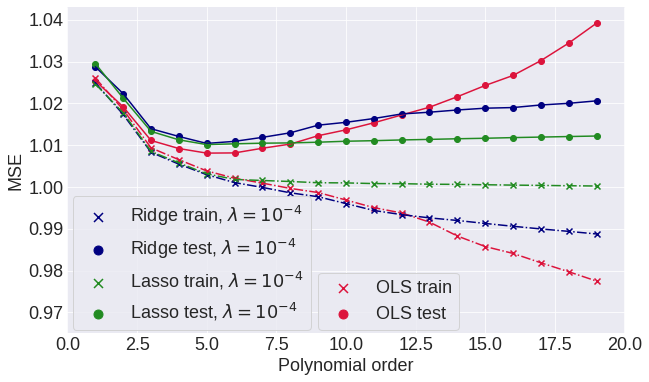

In [32]:
plt.figure(figsize=(10,6))
plot1 = plt.scatter(poly_orders_f, error_train_list_OLS_f, label="OLS train", marker="x", color="crimson")
plt.plot(poly_orders_f, error_train_list_OLS_f, color="crimson", ls="-.")
plot2 = plt.scatter(poly_orders_f, error_test_list_OLS_f, label="OLS test", color="crimson")
plt.plot(poly_orders_f, error_test_list_OLS_f, color="crimson")

plot3 = plt.scatter(poly_orders_f, error_train_list_Ridge4_f, label="Ridge train, $\lambda=10^{-4}$", marker="x", color="navy")
plt.plot(poly_orders_f, error_train_list_Ridge4_f, color="navy", ls="-.")
plot4 = plt.scatter(poly_orders_f, error_test_list_Ridge4_f, label="Ridge test, $\lambda=10^{-4}$", color="navy")
plt.plot(poly_orders_f, error_test_list_Ridge4_f, color="navy")

plot5 = plt.scatter(poly_orders_f, error_train_list_Lasso_f, label="Lasso train, $\lambda=10^{-4}$", marker="x", color="forestgreen")
plt.plot(poly_orders_f, error_train_list_Lasso_f, color="forestgreen", ls="-.")
plot6 = plt.scatter(poly_orders_f, error_test_list_Lasso_f, label="Lasso test, $\lambda=10^{-4}$", color="forestgreen")
plt.plot(poly_orders_f, error_test_list_Lasso_f, color="forestgreen")

legend1 = plt.legend(handles=[plot3, plot4, plot5, plot6], frameon=True, fontsize=18, loc=(0.01, 0.01), markerscale=1.5);
ax = plt.gca().add_artist(legend1)
plt.legend(handles=[plot1, plot2], frameon=True, fontsize=18, loc=(0.45, 0.01), markerscale=1.5);
plt.ylim(0.965, 1.043)
plt.xlabel("Polynomial order")
plt.ylabel("MSE")
plt.savefig("../figs/Franke_OLS_Ridge_polyorders.pdf", bbox_inches="tight");

## 1.2 Terrain Data
### 1.2.1 Downsampled by 32x32

In [3]:
terrain0 = imread("../input_data/SRTM_data_Norway_1.tif")/1000
terrain32 = skimage.measure.block_reduce(terrain0, (32, 32), np.mean)
reg = Regression()
reg.load_matrix_data(terrain32); terrain32.shape

(113, 57)

In [4]:
poly_orders_32 = np.arange(0, 65, 3)

In [5]:
error_train_list_OLS_32, error_test_list_OLS_32 = bias_variance("OLS", poly_orders_32, nr_averages=20)

100%|██████████| 22/22 [00:27<00:00,  4.27s/it]


In [6]:
error_train_list_Ridge6_32, error_test_list_Ridge6_32 = bias_variance("Ridge", poly_orders_32, lamda=1e-6, nr_averages=20)

100%|██████████| 22/22 [00:21<00:00,  3.36s/it]


In [8]:
# error_train_list_Lasso6_32, error_test_list_Lasso6_32 = bias_variance("Lasso", poly_orders_32, lamda=1e-4, nr_averages=1, tol=1e-3)

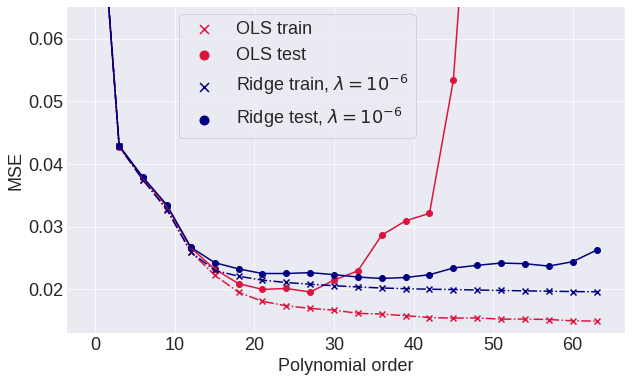

In [11]:
plt.figure(figsize=(10,6))
plt.scatter(poly_orders_32, error_train_list_OLS_32, label="OLS train", marker="x", color="crimson")
plt.plot(poly_orders_32, error_train_list_OLS_32, ls="-.", color="crimson")
plt.scatter(poly_orders_32, error_test_list_OLS_32, label="OLS test", color="crimson")
plt.plot(poly_orders_32, error_test_list_OLS_32, color="crimson")

plt.scatter(poly_orders_32, error_train_list_Ridge6_32, label="Ridge train, $\lambda = 10^{-6}$", marker="x", color="navy")
plt.plot(poly_orders_32, error_train_list_Ridge6_32, ls="-.", color="navy")
plt.scatter(poly_orders_32, error_test_list_Ridge6_32, label="Ridge test, $\lambda = 10^{-6}$", color="navy")
plt.plot(poly_orders_32, error_test_list_Ridge6_32, color="navy")

#plt.scatter(poly_orders, error_train_list_Lasso4, label="train error Lasso 4", marker="x", color="forestgreen")
#plt.plot(poly_orders, error_train_list_Lasso4, ls="-.", color="forestgreen")
#plt.scatter(poly_orders, error_test_list_Lasso4, label="test_error Lasso 4", color="forestgreen")
#plt.plot(poly_orders, error_test_list_Lasso4, color="forestgreen")

plt.ylim(0.013000, 0.065)
plt.xlabel("Polynomial order")
plt.ylabel("MSE")
plt.legend(fontsize=18, loc=(0.2, 0.60), frameon=True, markerscale=1.5);
plt.savefig("../figs/OLS_Ridge_Terrain_32sample.pdf", bbox_inches="tight");

### 1.2.2 Downsampled by 8x8

In [52]:
terrain0 = imread("../input_data/SRTM_data_Norway_1.tif")/1000
terrain1 = skimage.measure.block_reduce(terrain0, (8, 8), np.mean)
reg.load_matrix_data(terrain1); terrain1.shape

(451, 226)

In [35]:
poly_orders = np.arange(0, 132, 5)

In [ ]:
error_train_list_OLS, error_test_list_OLS = bias_variance("OLS", poly_orders, nr_averages=10)

In [ ]:
error_train_list_Ridge4, error_test_list_Ridge4 = bias_variance("Ridge", poly_orders, lamda=1e-4, nr_averages=10)

In [36]:
#np.save("../data/error_train_OLS_110.npy", error_train_list_OLS)
#np.save("../data/error_test_OLS_110.npy", error_test_list_OLS)
#np.save("../data/error_train_Ridge6_110.npy", error_train_list_Ridge6)
#np.save("../data/error_test_Ridge6_110.npy", error_test_list_Ridge6)
#np.save("../data/error_train_Ridge4_110.npy", error_train_list_Ridge4)
#np.save("../data/error_test_Ridge4_110.npy", error_test_list_Ridge4)

error_train_list_OLS = np.load("../data/error_train_OLS_110.npy")/1000**2
error_test_list_OLS = np.load("../data/error_test_OLS_110.npy")/1000**2
error_train_list_Ridge6 = np.load("../data/error_train_Ridge6_110.npy")/1000**2
error_test_list_Ridge6 = np.load("../data/error_test_Ridge6_110.npy")/1000**2
error_train_list_Ridge4 = np.load("../data/error_train_Ridge4_110.npy")/1000**2
error_test_list_Ridge4 = np.load("../data/error_test_Ridge4_110.npy")/1000**2

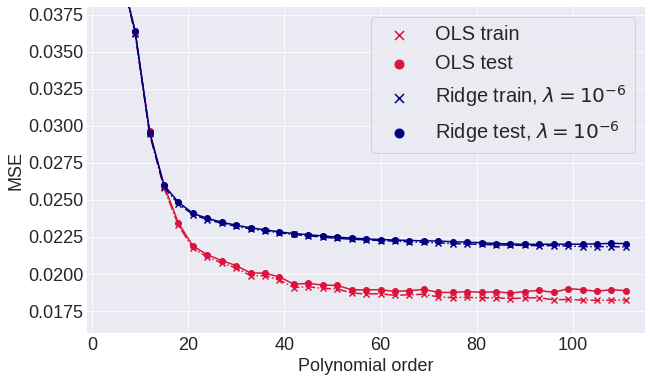

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(poly_orders, error_train_list_OLS, label="OLS train", marker="x", color="crimson")
plt.plot(poly_orders, error_train_list_OLS, ls="-.", color="crimson")
plt.scatter(poly_orders, error_test_list_OLS, label="OLS test", color="crimson")
plt.plot(poly_orders, error_test_list_OLS, color="crimson")

plt.scatter(poly_orders, error_train_list_Ridge6, label="Ridge train, $\lambda = 10^{-6}$", color="navy", marker="x")
plt.plot(poly_orders, error_train_list_Ridge6, color="navy", ls="-.")
plt.scatter(poly_orders, error_test_list_Ridge6, label="Ridge test, $\lambda = 10^{-6}$", color="navy")
plt.plot(poly_orders, error_test_list_Ridge6, color="navy")

plt.legend(fontsize=20, markerscale=1.5, frameon=True);
plt.ylim(0.016, 0.038)
plt.xlim(-1, 115)
plt.xlabel("Polynomial order")
plt.ylabel("MSE")
plt.savefig("../figs/OLS_Ridge_8sample_poly110.pdf", bbox_inches="tight");

## 1.3 Rerunning 32x32 downsampling for interval [0,2]

In [53]:
reg = Regression()
reg.load_matrix_data(terrain1, x=np.linspace(0, 2, terrain1.shape[1]), y=np.linspace(0, 2, terrain1.shape[0])); terrain1.shape

(451, 226)

In [62]:
poly_orders_2 = np.arange(0, 40, 3)

In [63]:
error_train_list_OLS_2, error_test_list_OLS_2 = bias_variance("OLS", poly_orders_2, nr_averages=10)

100%|██████████| 14/14 [00:22<00:00,  3.53s/it]


In [64]:
error_train_list_Ridge6_2, error_test_list_Ridge6_2 = bias_variance("Ridge", poly_orders_2, lamda=1e-6, nr_averages=10)

100%|██████████| 14/14 [00:22<00:00,  3.52s/it]


In [65]:
error_train_list_Ridge4_2, error_test_list_Ridge4_2 = bias_variance("Ridge", poly_orders_2, lamda=1e-4, nr_averages=10)

100%|██████████| 14/14 [00:22<00:00,  3.53s/it]


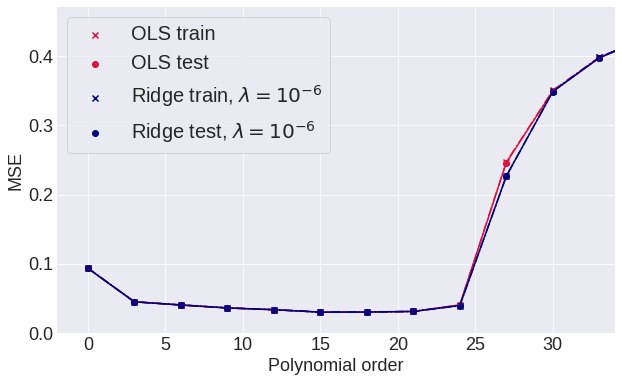

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(poly_orders_2, error_train_list_OLS_2, label="OLS train", color="crimson", marker="x")
plt.plot(poly_orders_2, error_train_list_OLS_2, color="crimson", ls="-.")
plt.scatter(poly_orders_2, error_test_list_OLS_2, label="OLS test", color="crimson")
plt.plot(poly_orders_2, error_test_list_OLS_2, color="crimson")

plt.scatter(poly_orders_2, error_train_list_Ridge6_2, label="Ridge train, $\lambda = 10^{-6}$", color="navy", marker="x")
plt.plot(poly_orders_2, error_train_list_Ridge6_2, color="navy", ls="-.")
plt.scatter(poly_orders_2, error_test_list_Ridge6_2, label="Ridge test, $\lambda = 10^{-6}$", color="navy")
plt.plot(poly_orders_2, error_test_list_Ridge6_2, color="navy")

#plt.ylim(20000, 99000)
plt.xlim(-2, 34)
plt.legend(fontsize=20, frameon=True);
plt.xlabel("Polynomial order")
plt.ylabel("MSE")
plt.savefig("../figs/OLS_Ridge_0to2divergence.pdf", bbox_inches="tight")